In [1]:
import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import coint

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [9]:
future=pd.read_csv('future_panel_hourly.csv',index_col=0,parse_dates=True)
coin_price=pd.read_csv('coin_panel_hourly.csv',index_col=0,parse_dates=True)
funding=pd.read_csv('funding_panel.csv',index_col=0,parse_dates=True)

funding.drop(['info','symbol','fundingRate','timestamp','datetime'],axis=1,inplace=True)





### 펀딩비를 고려하지 않고 같은 코인 선물 만으로 백테스팅 해보자

필요한 함수들

#### 50시간동안 공적분 검정을 하고 25일동안 trading하는 pair trading 전략을 백테스팅 해보자. 

#### 각각의 공적분 검정기간 동안 공적분 검정 기각역이 가장 큰 pair를 trading 한다고 하자. 즉 기간마다 pair가 바뀔 수 있다

In [16]:
def E_Gtest(y,x):
    return coint(y,x,maxlag=12)[0]


def get_spread(y,x):
    results=sm.OLS(y,x).fit()
    spread=results.resid
    spread=pd.Series(spread,name='spread')
    return spread

def adf_test(x,cutoff=0.01):
    pvalue=adfuller(x)[1]
    if pvalue<cutoff:
        print('stationary')
    else:
        print('no')


def find_distance(a,b):
    dist=np.linalg.norm(a-b)
    return dist
    
def mm_scaler(df):
    for i in df.columns:
        df[i]=(df[i]-np.min(df[i]))/(np.max(df[i])-np.min(df[i]))
    return df

In [99]:
def testing_day(coin_price,future,train_start,train_end,test_start,test_end):
    coin_price1=coin_price.iloc[train_start:train_end].copy()
    coin_price2=coin_price.iloc[test_start:test_end].copy()
    future1=future.iloc[train_start:train_end].copy()
    future2=future.iloc[test_start:test_end].copy()

    return coin_price1,coin_price2,future1,future2


def pair_selection(coin_price1_scaled, future1_scaled):
    coin_price_columns=set(coin_price1_scaled.columns)
    future_columns=set(future1_scaled.columns)

    common_columns=coin_price_columns.intersection(future_columns)
    common_columns=list(common_columns)
    pairs=dict()
    for ticker in common_columns:
        temp_coin=coin_price1_scaled[ticker]
        temp_future=future1_scaled[ticker]
        dist=find_distance(temp_coin,temp_future)
        pairs[dist]=ticker

    key_list=list(pairs.keys())
    key_list=sorted(key_list)[0:5]
    value_list=[]
    for key in key_list:
        value_list.append(pairs[key])
        
    return value_list,key_list




def back_test(ticker,coin_price2,future2,s=2):
    df=pd.DataFrame(index=coin_price2.index,columns=columns)
    df['ticker']=coin_price2[ticker]
    df['ticker_future']=future2[ticker]
    df['spread']=get_spread(df['ticker_future'],df['ticker'])
    df['spread_n']=(df['spread'].copy()-df['spread'].mean())/df['spread'].std()
    df['total']=df['ticker']+df['ticker_future']
    threshold1=df['spread_n'].std()*s+df['spread_n'].mean()
    threshold2=df['spread_n'].std()*-s+df['spread_n'].mean()

    df['position']=np.where(df['spread_n']>threshold1,-1,np.nan)
    df['position']=np.where(df['spread_n']<threshold2,1,df['position'])
    df['position']=np.where(df['spread_n']*df['spread_n'].shift(1)<0,0,df['position'])
    df['position']=df['position'].ffill().fillna(0)

    df['spread_return']=np.log(df['spread']/df['spread'].shift(1))
    df['t_return']=np.log(df['total']/df['total'].shift(1))
    df['strategy']=(df['spread_return'])*df['position'].shift(1)

    return df



AXS/USDT
t_return    0.254970
strategy    2.652004
dtype: float64
ANC/USDT
t_return    8.330801
strategy    5.962518
dtype: float64
HOT/USDT
t_return    0.586795
strategy    0.415755
dtype: float64
GTC/USDT
t_return    1.789254
strategy    1.000000
dtype: float64
ETH/USDT
t_return    0.133887
strategy    1.000000
dtype: float64
GMT/USDT
t_return    17.259477
strategy     1.000000
dtype: float64
SNX/USDT
t_return    0.396404
strategy    8.548921
dtype: float64
ANC/USDT
t_return    22.639146
strategy     0.035371
dtype: float64
1INCH/USDT
t_return    0.242639
strategy    0.467948
dtype: float64
CELR/USDT
t_return    0.167692
strategy    0.518301
dtype: float64
WAVES/USDT
t_return    0.188616
strategy    0.024060
dtype: float64
IOST/USDT
t_return     9.781990
strategy    53.178198
dtype: float64
AAVE/USDT
t_return    0.062638
strategy    1.000000
dtype: float64
ROSE/USDT
t_return     2.373173
strategy    14.266309
dtype: float64
KNC/USDT
t_return    9.731489
strategy    0.443730
dtype: fl

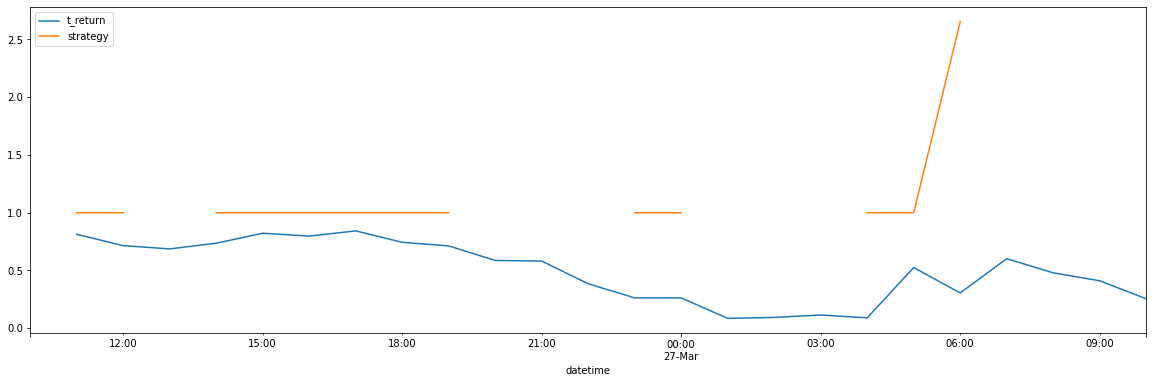

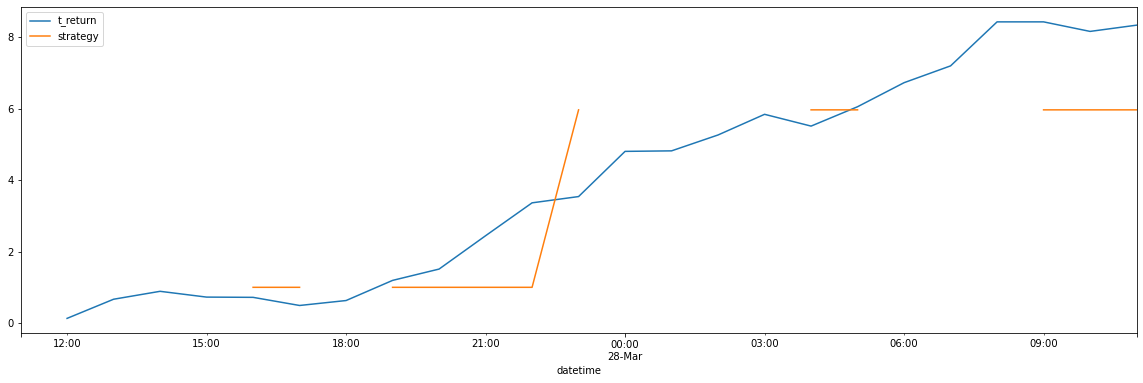

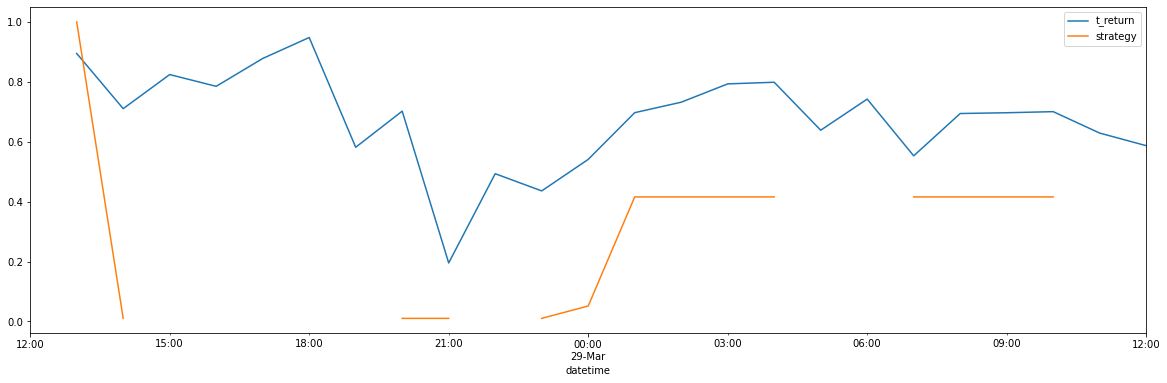

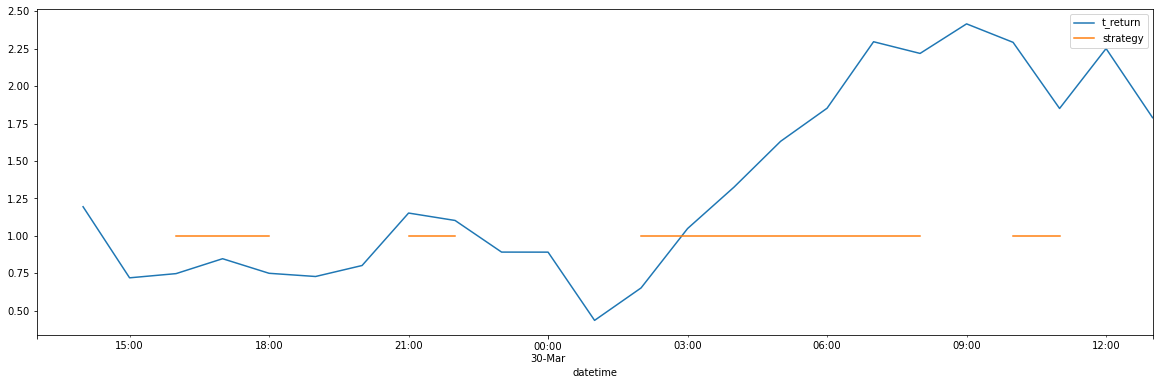

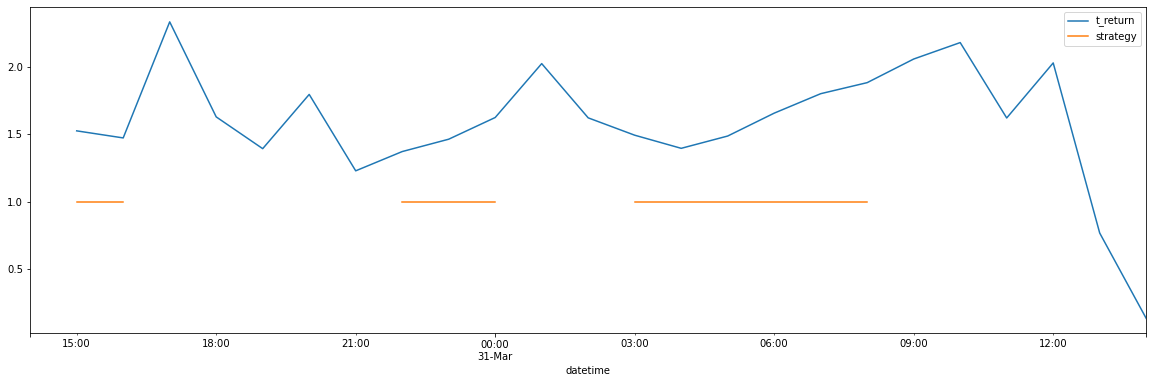

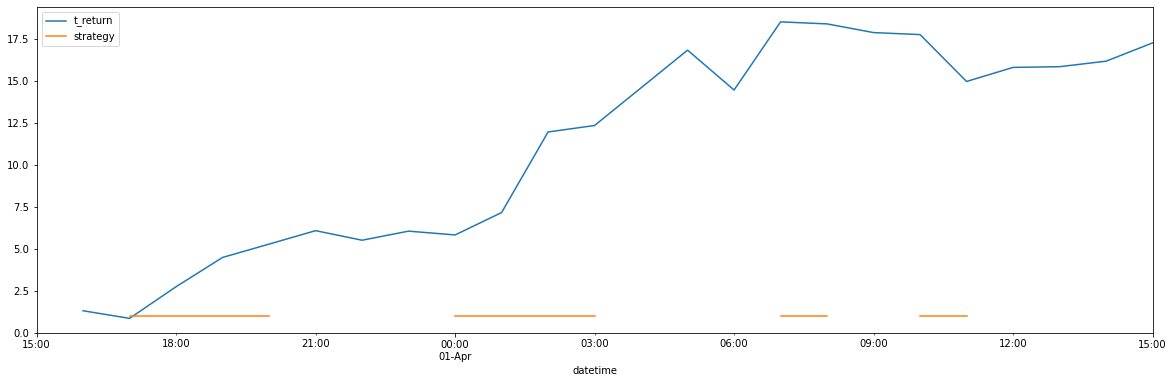

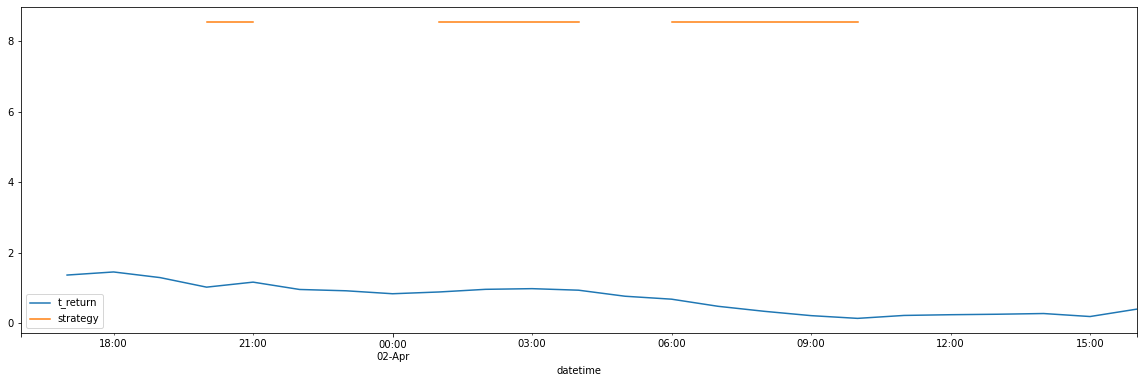

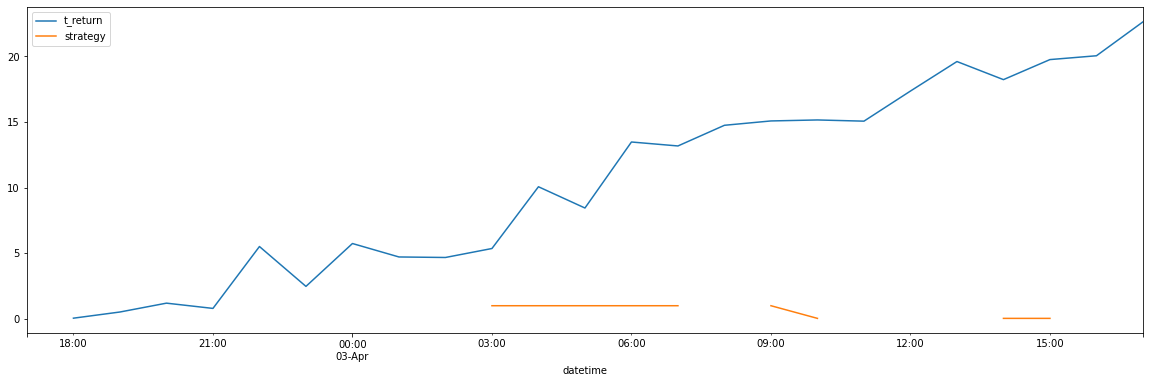

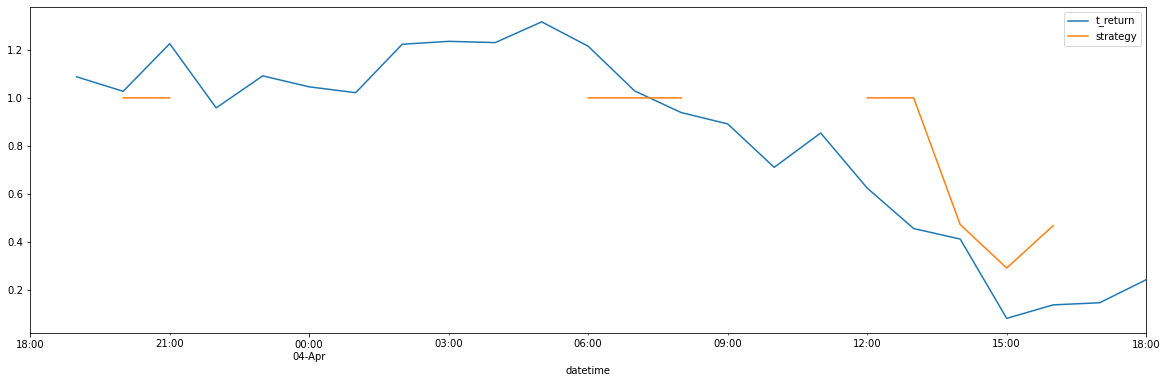

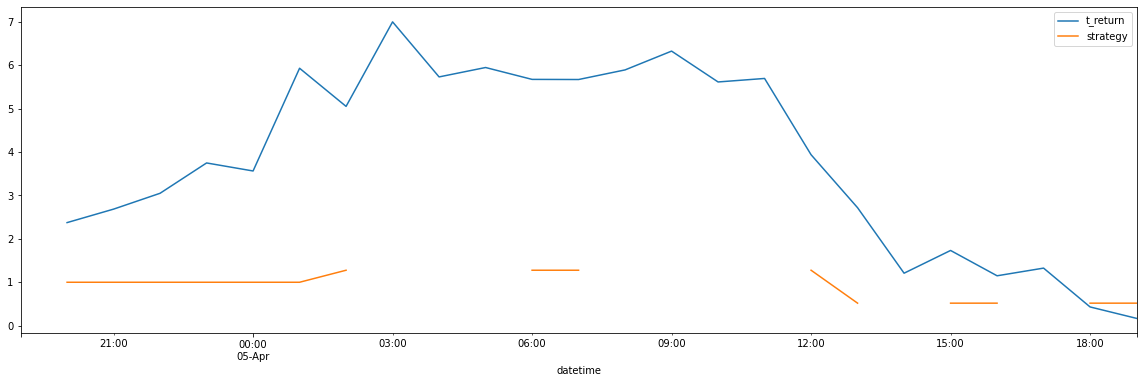

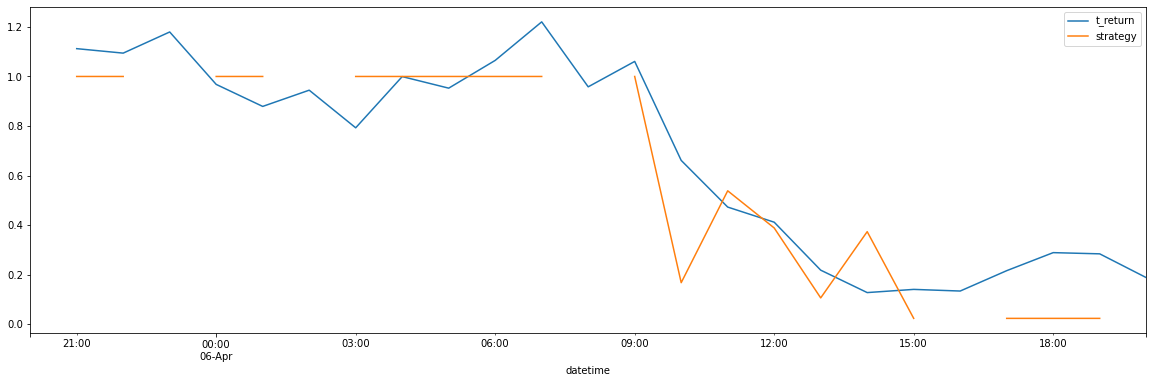

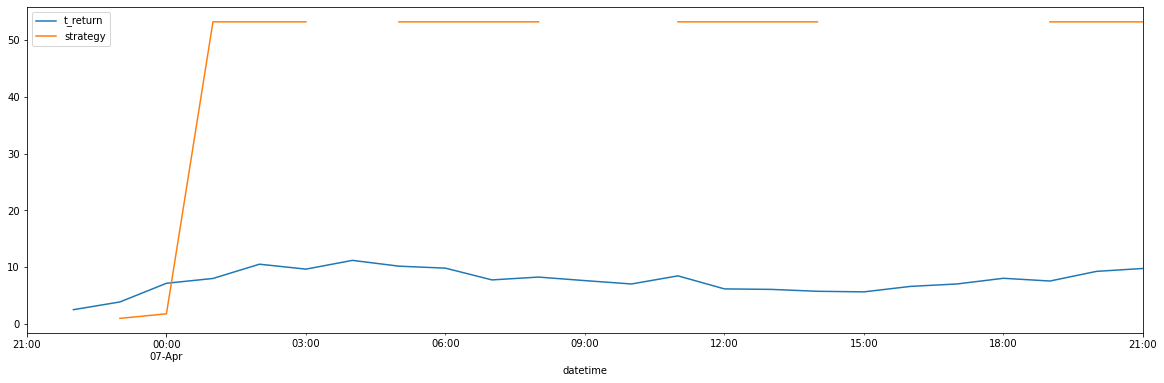

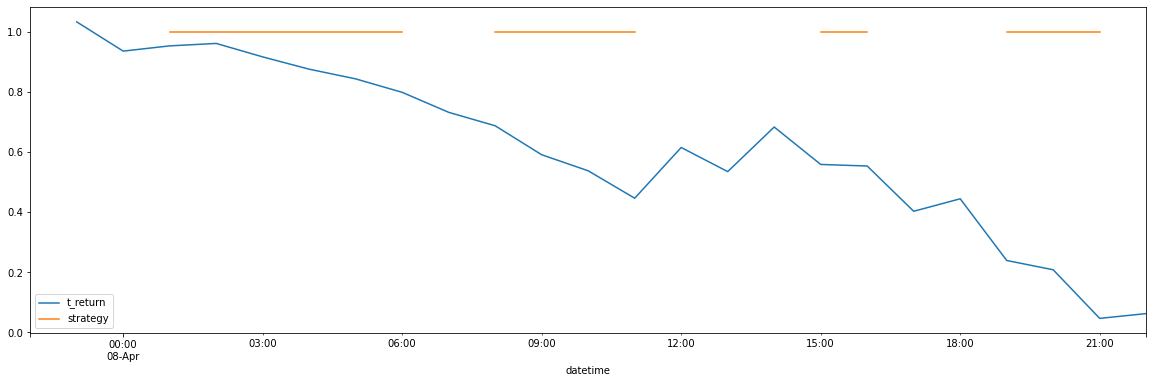

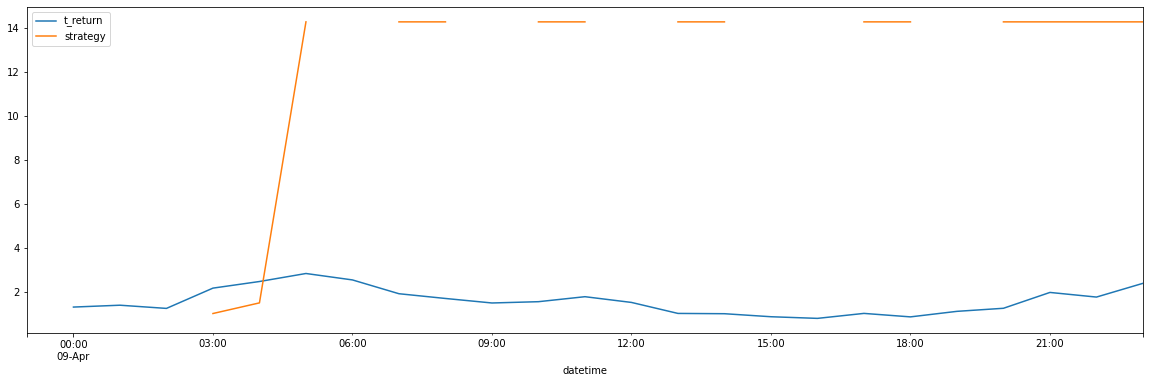

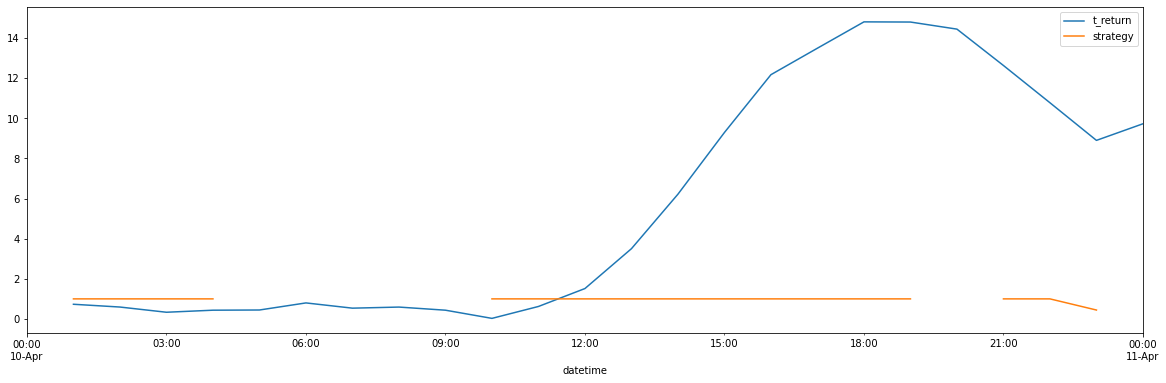

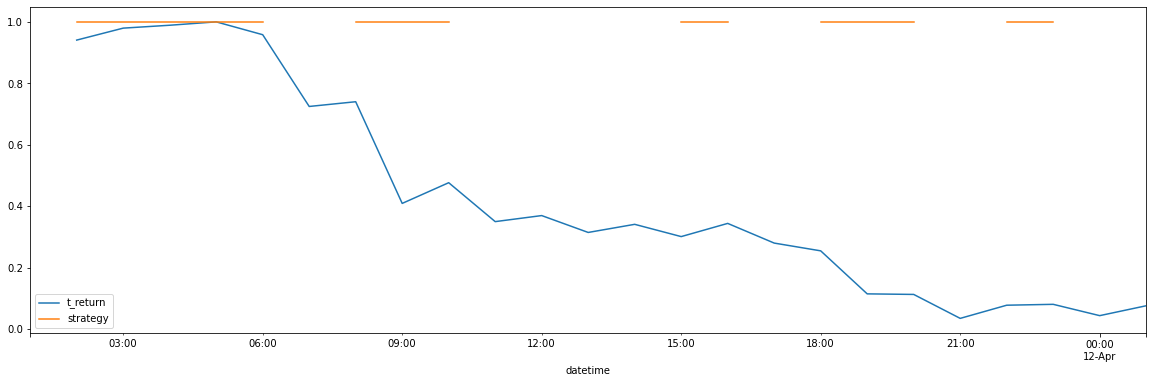

In [104]:
future=pd.read_csv('future_panel_hourly.csv',index_col=0,parse_dates=True)
coin_price=pd.read_csv('coin_panel_hourly.csv',index_col=0,parse_dates=True)
train=list(range(0,424,25))
test=list(range(75,474,25))
total_stratey_return=0
total_buy_and_rebalance_return=0
for i,j in zip(train,test):
    coin_price1,coin_price2,future1,future2=testing_day(coin_price,future,train_start=i,train_end=i+50,test_start=j,test_end=j+25)
    coin_price1_scaled=mm_scaler(coin_price1)
    future1_scaled=mm_scaler(future1)
    coin_price2_scaled=mm_scaler(coin_price2)
    future2_scaled=mm_scaler(future2)

    value_list,key_list=pair_selection(coin_price1_scaled=coin_price1_scaled,future1_scaled=future1_scaled)
    ticker=value_list[0]
    print(ticker)
    df=back_test(ticker=ticker,coin_price2=coin_price2,future2=future2)
    print(df[['t_return','strategy']].sum().apply(np.exp))
    stratey_return=np.exp(df['strategy'].sum())
    total_stratey_return+=stratey_return
    buy_and_rebalance_return=np.exp(df['t_return'].sum())
    total_buy_and_rebalance_return+=buy_and_rebalance_return
    df[['t_return','strategy']].cumsum().apply(np.exp).plot(figsize=(20,6))

print(f'total strategy return: {total_stratey_return}')
print(f'total buy and rebalance return: {total_buy_and_rebalance_return}')





    


 위에 처럼 공적분 검정기간 50시간 trading 기간 20시간으로 짜지 않고 전체를 3등분해서 그 중 2/3은 공적분 검정기간 1/3은 trading 기간으로 했을 때의 전략 

In [70]:
coin_price1=coin_price.iloc[:300].copy()
coin_price2=coin_price.iloc[300:].copy()
future1=future.iloc[:300].copy()
future2=future.iloc[300:].copy()
coin_price1_scaled=mm_scaler(coin_price1)
future1_scaled=mm_scaler(future1)
coin_price2_scaled=mm_scaler(coin_price2)
future2_scaled=mm_scaler(future2)
coin_price_columns=set(coin_price1.columns)
future_columns=set(future1.columns)

common_columns=coin_price_columns.intersection(future_columns)
common_columns=list(common_columns)


pairs=dict()
for ticker in common_columns:
    temp_coin=coin_price1_scaled[ticker]
    temp_future=future1_scaled[ticker]
    dist=find_distance(temp_coin,temp_future)
    pairs[dist]=ticker

key_list=list(pairs.keys())
key_list=sorted(key_list)[0:5]
value_list=[]
for key in key_list:
    value_list.append(pairs[key])
print(value_list)

['SC/USDT', 'AAVE/USDT', 'SNX/USDT', 'CELO/USDT', 'ETH/USDT']


In [71]:
for pair in value_list:
    adf_test(coin_price1_scaled[pair])
    adf_test(future1_scaled[pair])

no
no
no
no
no
no
no
no
no
no


In [73]:
for pair in value_list:
    coint_result=E_Gtest(coin_price1_scaled[pair].dropna(),future1_scaled[pair].dropna())
    print(coint_result)

-5.095530051857204
-4.421020423343966
-4.319175751099098
-4.856789006730068
-4.183247202571856


In [86]:
s=2
columns=['SC/USDT','SC/USDT_future']
df=pd.DataFrame(index=coin_price2.index,columns=columns)
df['SC/USDT']=coin_price2['SC/USDT']
df['SC/USDT_future']=future2['SC/USDT']
df['spread']=get_spread(df['SC/USDT_future'],df['SC/USDT'])
df['spread_n']=(df['spread'].copy()-df['spread'].mean())/df['spread'].std()
df['total']=df['SC/USDT']+df['SC/USDT_future']
threshold1=df['spread_n'].std()*s+df['spread_n'].mean()
threshold2=df['spread_n'].std()*-s+df['spread_n'].mean()

df['position']=np.where(df['spread_n']>threshold1,-1,np.nan)
df['position']=np.where(df['spread_n']<threshold2,1,df['position'])
df['position']=np.where(df['spread_n']*df['spread_n'].shift(1)<0,0,df['position'])
df['position']=df['position'].ffill().fillna(0)

df['spread_return']=np.log(df['spread']/df['spread'].shift(1))
df['t_return']=np.log(df['total']/df['total'].shift(1))
df['strategy']=(df['spread_return'])*df['position'].shift(1)




In [88]:
print(df['position'].value_counts())

 0.0    189
 1.0     10
-1.0      1
Name: position, dtype: int64


t_return    0.216168
strategy    0.377988
dtype: float64


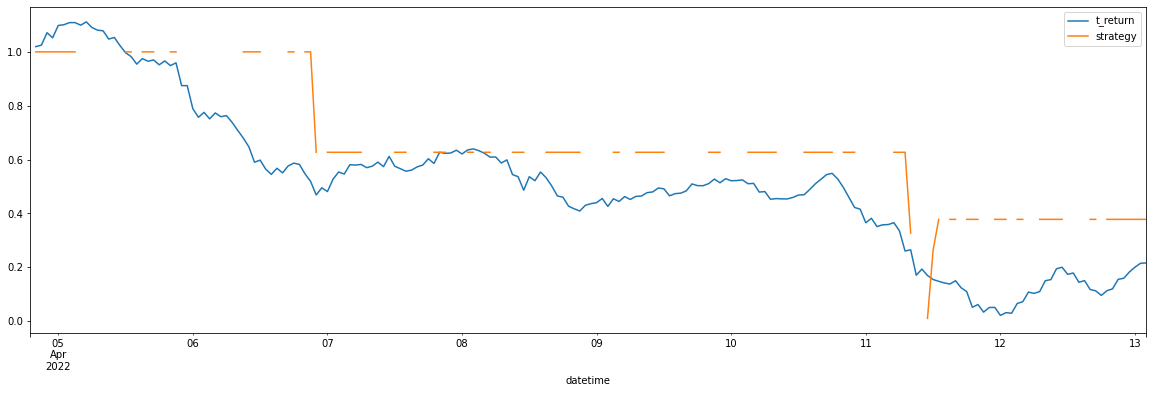

In [87]:
df[['t_return','strategy']].cumsum().apply(np.exp).plot(figsize=(20,6))

print(df[['t_return','strategy']].sum().apply(np.exp))